# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Fixed-variances" data-toc-modified-id="Fixed-variances-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Fixed variances</a></div><div class="lev1 toc-item"><a href="#Sum-of-products,-all-parameters-free" data-toc-modified-id="Sum-of-products,-all-parameters-free-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Sum of products, all parameters free</a></div>

In [23]:
using TimeSeries
using DataFrames
using GaussianProcesses
using GaussianProcesses: Mean, Kernel, evaluate, metric, IsotropicData, VecF64
using GaussianProcesses: Stationary, KernelData, MatF64, predict
import GaussianProcesses: optimize!, get_optim_target, cov, grad_slice!
import GaussianProcesses: num_params, set_params!, get_params, update_mll!, update_mll_and_dmll!
import GaussianProcesses: get_param_names, cov!, addcov!, multcov!
import Proj4
using JLD
using Distances
using DataFrames: by, head
using Dates: tonext, Hour, Day

INFO: Recompiling stale cache file /Users/imolk/.julia/lib/v0.5/HDF5.ji for module HDF5.
INFO: Recompiling stale cache file /Users/imolk/.julia/lib/v0.5/JLD.ji for module JLD.


In [3]:
include("src/TempModel.jl")

TempModel

In [7]:
import PyPlot; plt=PyPlot
using LaTeXStrings
plt.rc("figure", dpi=300.0)
plt.rc("figure", figsize=(12,8))
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

In [8]:
isdList=TempModel.read_isdList()
isdSubset=isdList[[(usaf in (725450,725460,725480,725485)) for usaf in isdList[:USAF].values],:]
isdSubset

4×13 DataFrames.DataFrame
│ Row │ USAF   │ WBAN  │ NAME                             │ CTRY │ STATE │
├─────┼────────┼───────┼──────────────────────────────────┼──────┼───────┤
│ 1   │ 725450 │ 14990 │ THE EASTERN IOWA AIRPORT         │ US   │ IA    │
│ 2   │ 725460 │ 14933 │ DES MOINES INTERNATIONAL AIRPORT │ US   │ IA    │
│ 3   │ 725480 │ 94910 │ WATERLOO MUNICIPAL AIRPORT       │ US   │ IA    │
│ 4   │ 725485 │ 14940 │ MASON CITY MUNICIPAL ARPT        │ US   │ IA    │

│ Row │ ICAO │ LAT    │ LON     │ ELEV  │ BEGIN │ END  │ X_PRJ     │ Y_PRJ     │
├─────┼──────┼────────┼─────────┼───────┼───────┼──────┼───────────┼───────────┤
│ 1   │ KCID │ 41.883 │ -91.717 │ 264.6 │ 1973  │ 2015 │ 1.64799e6 │ 1.0441e6  │
│ 2   │ KDSM │ 41.534 │ -93.653 │ 291.7 │ 1973  │ 2015 │ 1.48723e6 │ 1.00379e6 │
│ 3   │ KALO │ 42.554 │ -92.401 │ 264.6 │ 1960  │ 2015 │ 1.59025e6 │ 1.11766e6 │
│ 4   │ KMCW │ 43.154 │ -93.327 │ 373.4 │ 1973  │ 2015 │ 1.51407e6 │ 1.18374e6 │

In [9]:
hourly_cat=TempModel.read_Stations(isdSubset)
itest=3
hourly_train = hourly_cat[hourly_cat[:station].values.!=itest,:]
hourly_test  = hourly_cat[hourly_cat[:station].values.==itest,:]
nrow(hourly_train), nrow(hourly_test)

(35169,12695)

In [10]:
hr_measure = Hour(17) # number between 0 and 24
hourly_test[:ts_day] = [TempModel.measurement_date(t, hr_measure) for t in hourly_test[:ts].values]
TnTx = DataFrames.by(hourly_test, :ts_day, df -> DataFrame(
    Tn=minimum(df[:temp].values), 
    Tx=maximum(df[:temp].values)))
test_trimmed=join(hourly_test, TnTx, on=:ts_day)
head(test_trimmed)

6×13 DataFrames.DataFrame
│ Row │ year │ month │ day │ hour │ min │ seconds │ temp  │
├─────┼──────┼───────┼─────┼──────┼─────┼─────────┼───────┤
│ 1   │ 2015 │ 1     │ 1   │ 0    │ 0   │ 0       │ -8.3  │
│ 2   │ 2015 │ 1     │ 1   │ 0    │ 54  │ 0       │ -8.9  │
│ 3   │ 2015 │ 1     │ 1   │ 1    │ 54  │ 0       │ -8.9  │
│ 4   │ 2015 │ 1     │ 1   │ 2    │ 54  │ 0       │ -9.4  │
│ 5   │ 2015 │ 1     │ 1   │ 3    │ 54  │ 0       │ -9.4  │
│ 6   │ 2015 │ 1     │ 1   │ 4    │ 54  │ 0       │ -10.0 │

│ Row │ ts                  │ station │ ts_hours │ ts_day     │ Tn    │ Tx   │
├─────┼─────────────────────┼─────────┼──────────┼────────────┼───────┼──────┤
│ 1   │ 2015-01-01T00:00:00 │ 3       │ 0.0      │ 2015-01-01 │ -11.1 │ -3.9 │
│ 2   │ 2015-01-01T00:54:00 │ 3       │ 0.9      │ 2015-01-01 │ -11.1 │ -3.9 │
│ 3   │ 2015-01-01T01:54:00 │ 3       │ 1.9      │ 2015-01-01 │ -11.1 │ -3.9 │
│ 4   │ 2015-01-01T02:54:00 │ 3       │ 2.9      │ 2015-01-01 │ -11.1 │ -3.9 │
│ 5   │ 2015-01-01T03:54:00 │ 3       │ 3.9      │ 2015-01-01 │ -11.1 │ -3.9 │
│ 6   │ 2015-01-01T04:54:00 │ 3       │ 4.9      │ 2015-01-01 │ -11.1 │ -3.9 │

In [11]:
function subset(df, from, to)
    after_from = df[:ts].values .>= from
    before_to = df[:ts].values .<= to
    return df[after_from & before_to,:]
end

subset (generic function with 1 method)

In [13]:
test_X_PRJ = isdSubset[:X_PRJ].values[test_subset[:station].values]
test_Y_PRJ = isdSubset[:Y_PRJ].values[test_subset[:station].values]
test_X = [test_subset[:ts_hours].values test_X_PRJ test_Y_PRJ]
;

In [14]:
function add_diag!(Σ::PDMats.PDMat, a::Float64)
    mat = Σ.mat
    for i in 1:size(mat,1)
        mat[i,i] += a
    end
    copy!(Σ.chol.factors, mat)
    cholfact!(Σ.chol.factors, Symbol(Σ.chol.uplo))
    @assert sumabs(mat .- full(Σ.chol)) < 1e-8
    return Σ
end
;

# Fixed variances

In [49]:
GPmodel="fixed_var"

"fixed_var"

In [17]:
saved_dir = joinpath(pwd(), "saved/predictions_from_nearby", GPmodel)

jldfiles = readdir(saved_dir)
filepath = jldfiles[5]
nearby_pred=load(joinpath(saved_dir, filepath))["nearby_pred"]

"/Users/imolk/Documents/Harvard/Natesh/temperature_model/saved/predictions_from_nearby/fixed_var"

In [42]:
test_subset = subset(test_trimmed, minimum(nearby_pred.ts), maximum(nearby_pred.ts))
train_subset = subset(hourly_train, minimum(nearby_pred.ts), maximum(nearby_pred.ts))
;

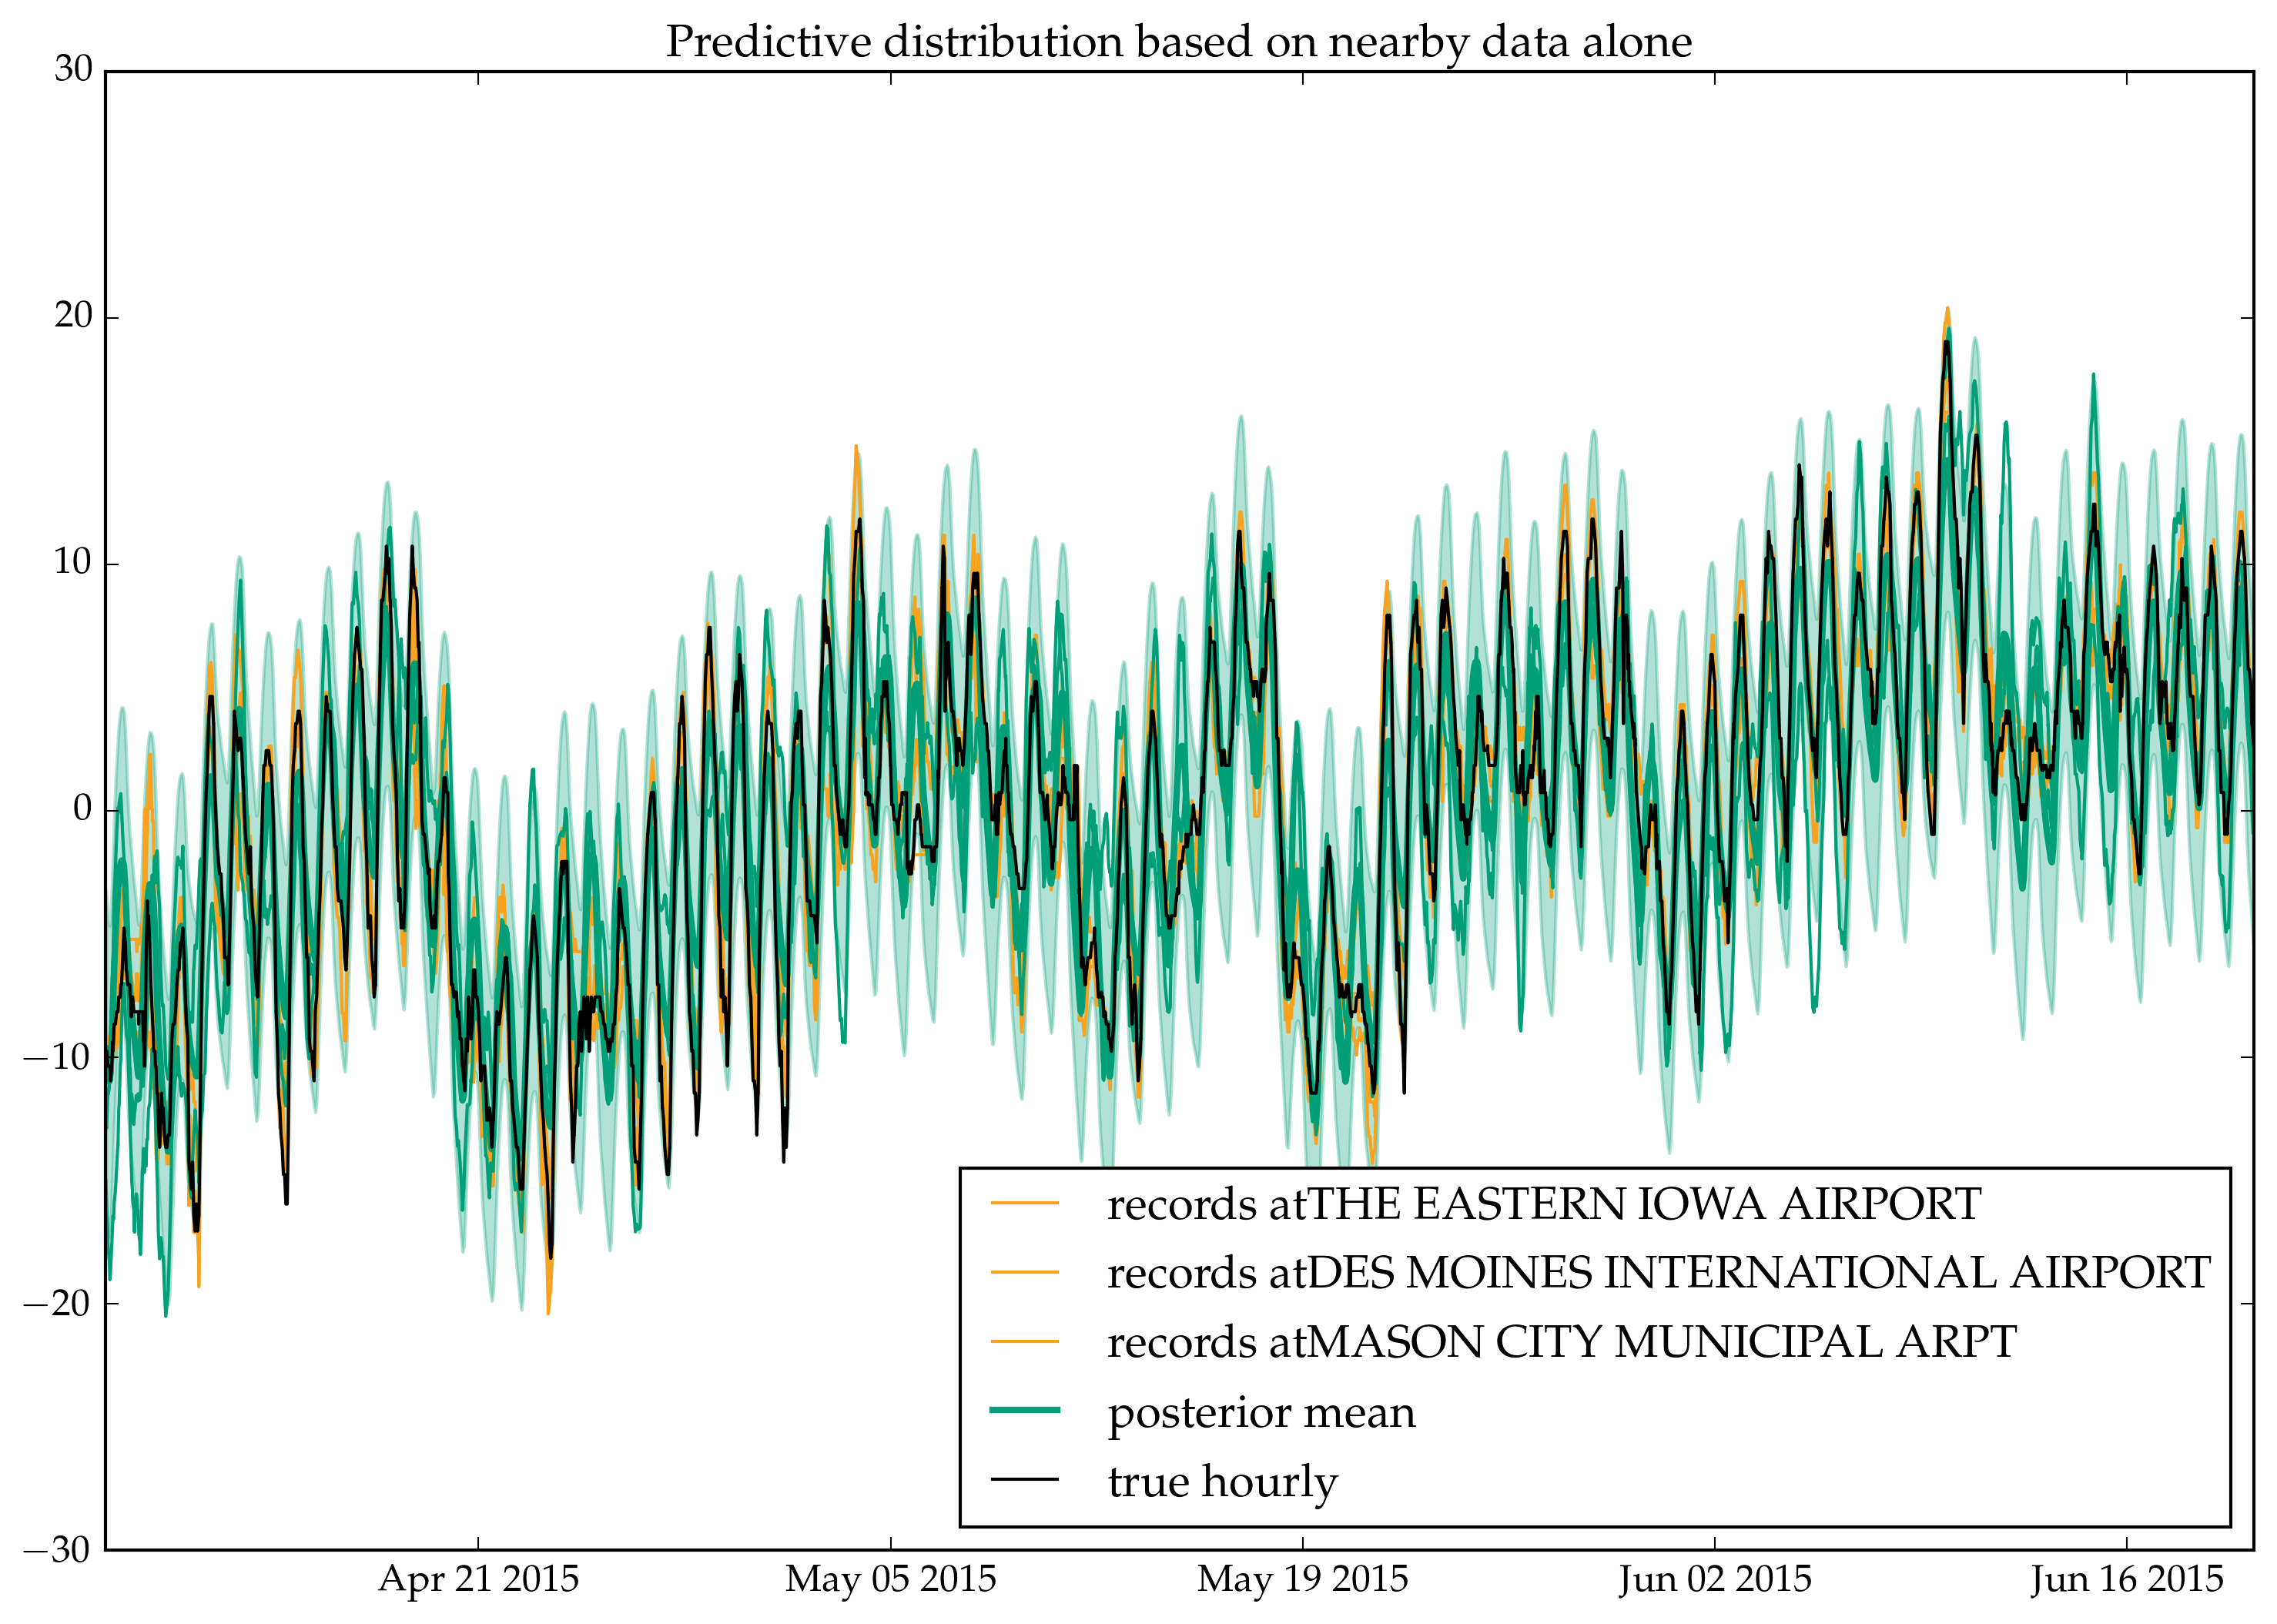

In [45]:
begin
    μ = nearby_pred.μ
    Σ = nearby_pred.Σ
    nobsv = length(μ)
    
    centering = eye(nobsv) .- (1.0/nobsv) .* ones(nobsv, nobsv)
    Σ_centered = centering * Σ.mat * centering
    distr = MultivariateNormal(μ, Σ)c
    for station in unique(train_subset[:station].values)
        sdata = train_subset[train_subset[:station].values.==station,:]
        ts=sdata[:ts].values
        plt.plot(ts, sdata[:temp].values.-mean(sdata[:temp].values), color="#F8A21F", 
            label="records at"get(isdSubset[station,:NAME]))
    end
    ts=test_subset[:ts].values
    plt.plot(ts, μ, color="#009F77", linewidth=2, label="posterior mean")
    for _ in 1:2
        temp_sim = rand(distr)
        plt.plot(ts, temp_sim.-mean(temp_sim), color="#009F77", linewidth=1)
    end
    plt.fill_between(ts, μ-2*√diag(Σ_centered),μ+2*√diag(Σ_centered), color="#009F77", alpha=0.3)
    ts = test_subset[:ts].values
    temp_true = test_subset[:temp].values
    plt.plot(ts, temp_true.-mean(temp_true), 
        color="black", "-", label="true hourly")
    plt.legend(loc="best")
    plt.title("Predictive distribution based on nearby data alone")
end
;

In [32]:
begin
    ts=test_subset[:ts].values
    μ = nearby_pred.μ
    Σ = nearby_pred.Σ
    nobsv = length(μ)
    
    centering = eye(nobsv) .- (1.0/nobsv) .* ones(nobsv, nobsv)
    Σ_centered = centering * Σ.mat * centering
    distr = MultivariateNormal(μ, Σ)
#     println("sum(Σ_centered)=", sum(Σ_centered*Σ_centered))
    for _ in 1:5
        temp_sim = rand(distr)
        println("var(predicted mean - simulated prediction)=", var(μ .- temp_sim))
    end
    temp_true = test_subset[:temp].values
    println("E(var(predicted mean - predictive draw))=", mean(var(μ .- rand(distr)) for _ in 1:10000))
    println("var(truth - predicted mean)=", var(μ .- temp_true))
end
;

var(predicted mean - simulated prediction)=10.399642081642805
var(predicted mean - simulated prediction)=9.656990909844728
var(predicted mean - simulated prediction)=8.031789279533152
var(predicted mean - simulated prediction)=9.721271091503402
var(predicted mean - simulated prediction)=7.506751552701928
E(var(predicted mean - predictive draw))=9.341490941912928
var(truth - predicted mean)=6.09060779661912


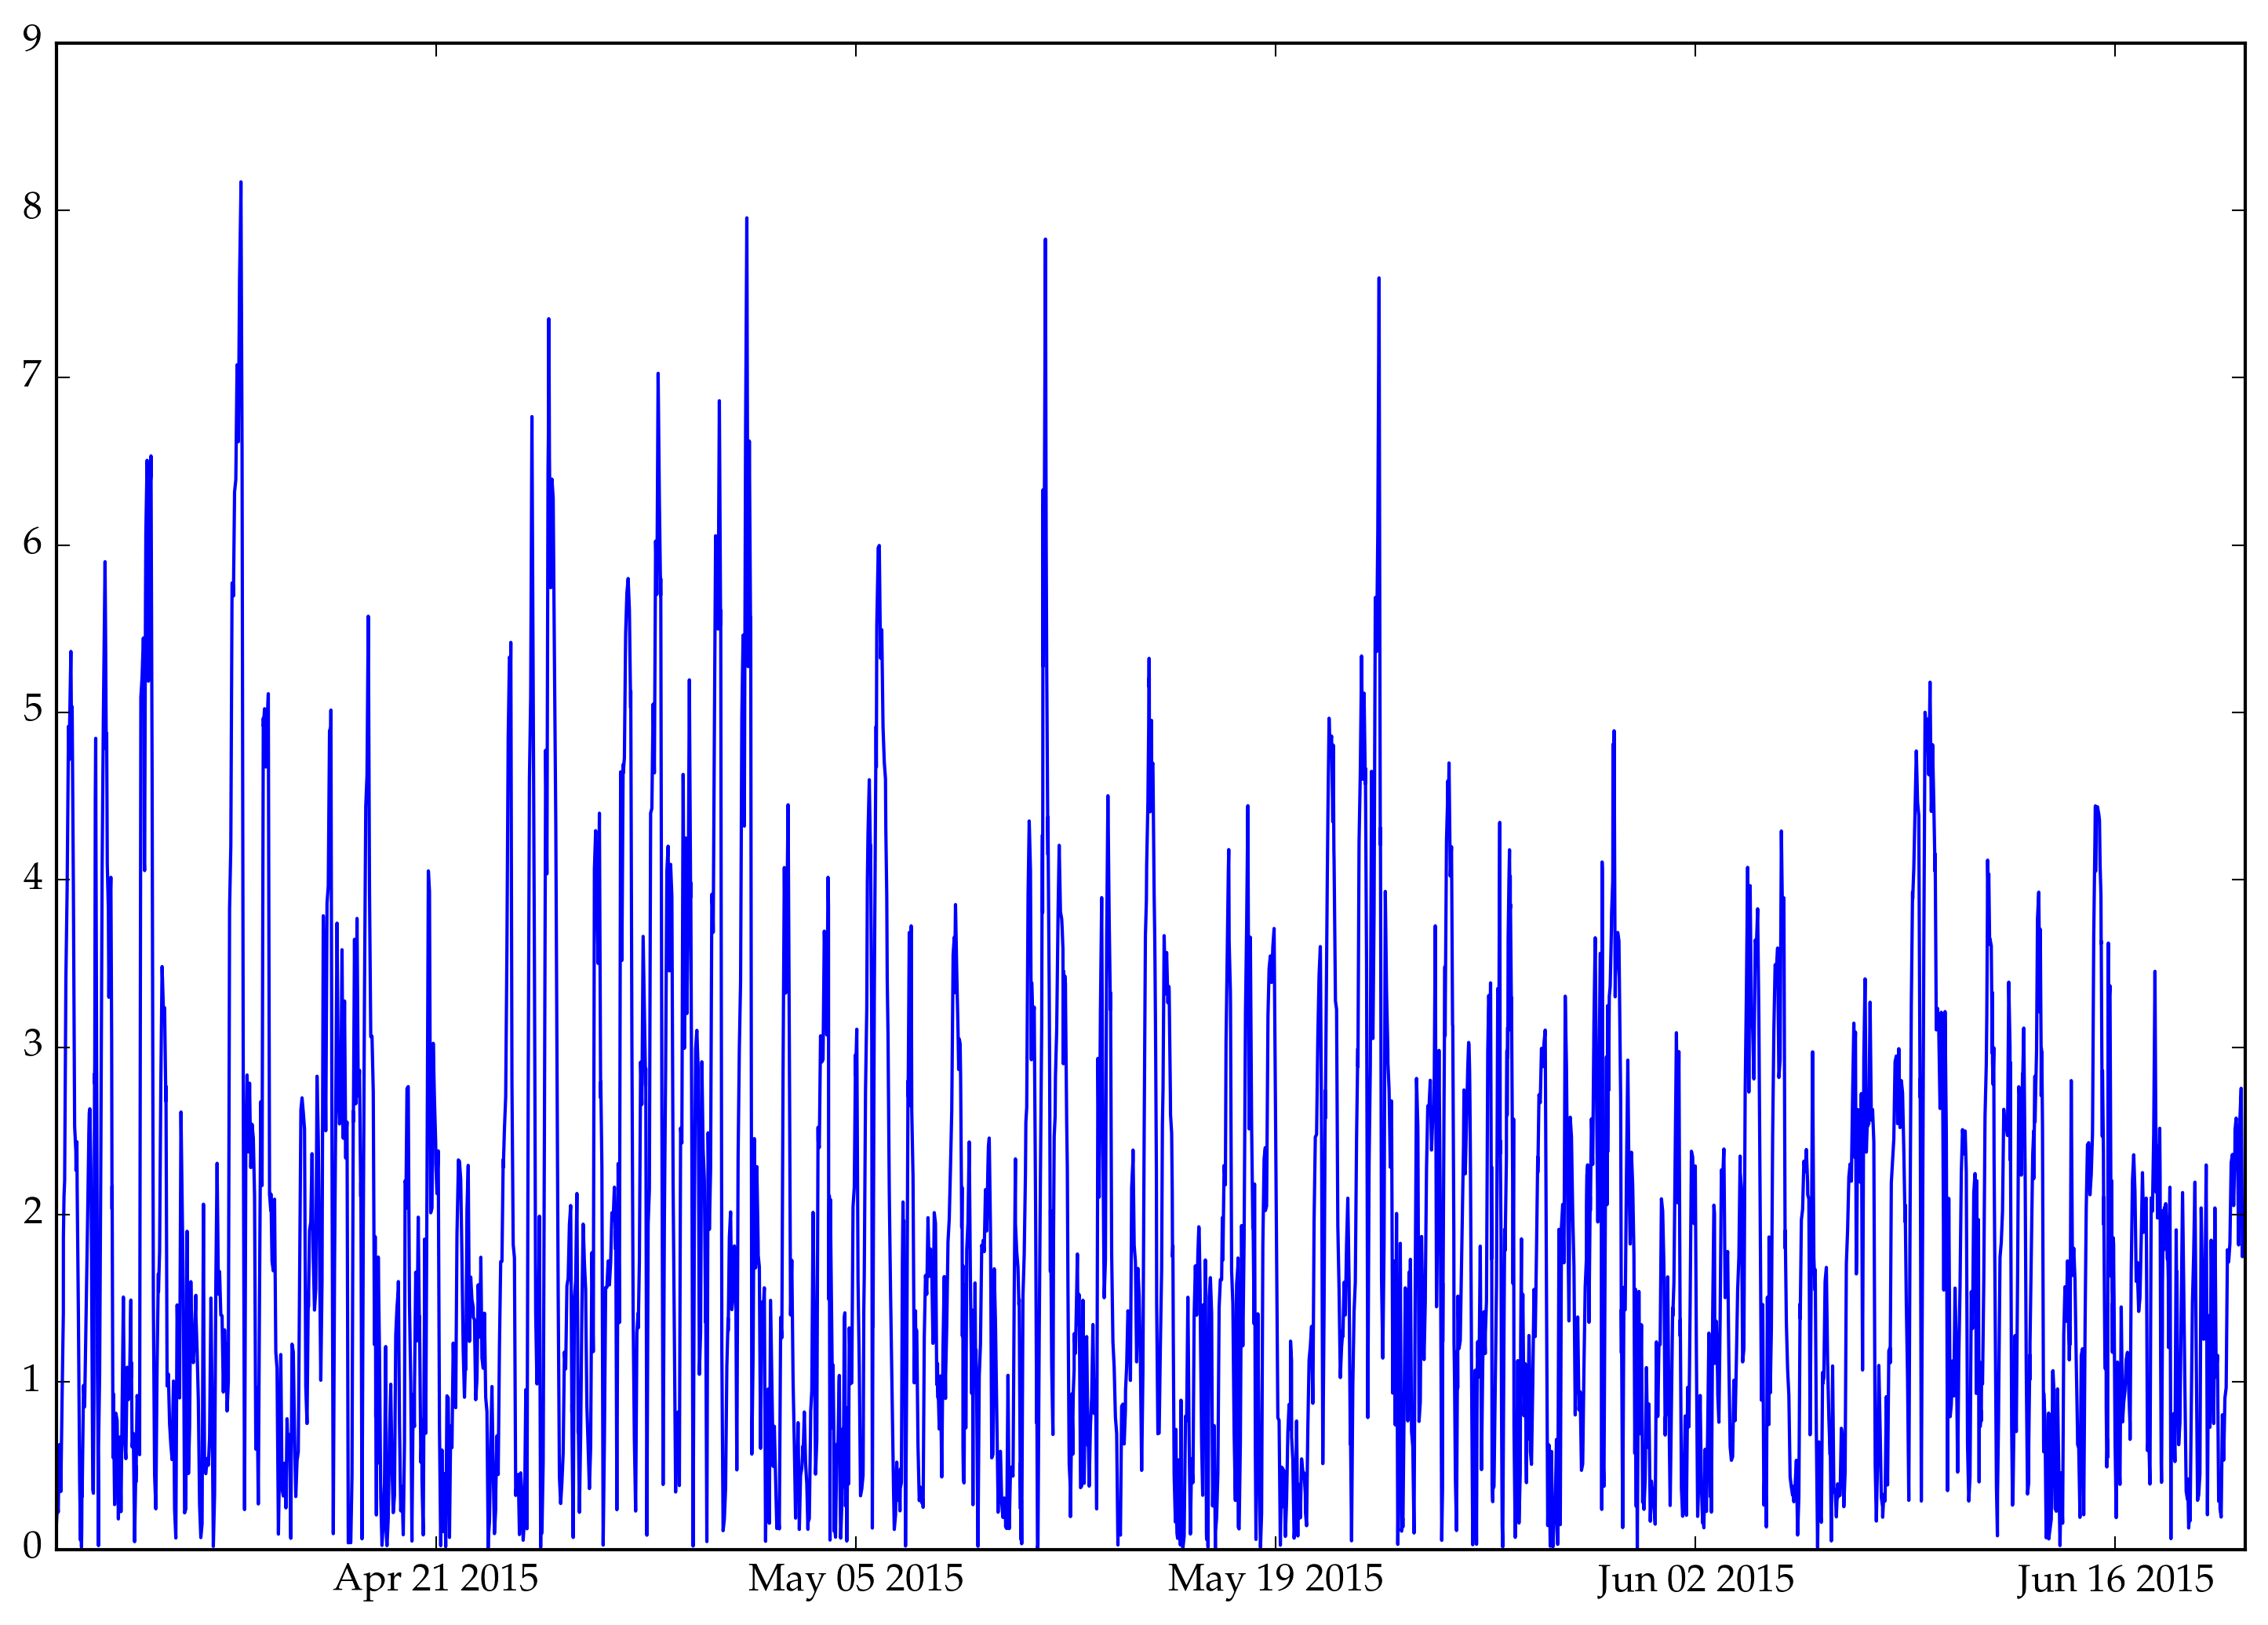

var(truth - predicted mean)=6.09060779661912


In [37]:
begin
    ts=test_subset[:ts].values
    μ = nearby_pred.μ
    Σ = nearby_pred.Σ
    nobsv = length(μ)
    
    centering = eye(nobsv) .- (1.0/nobsv) .* ones(nobsv, nobsv)
    Σ_centered = centering * Σ.mat * centering
    distr = MultivariateNormal(μ, Σ)
    temp_true = test_subset[:temp].values
    println("var(truth - predicted mean)=", var(μ .- temp_true))
    residuals = μ .- temp_true
    plt.plot(ts, abs(residuals .- mean(residuals)))
end
;

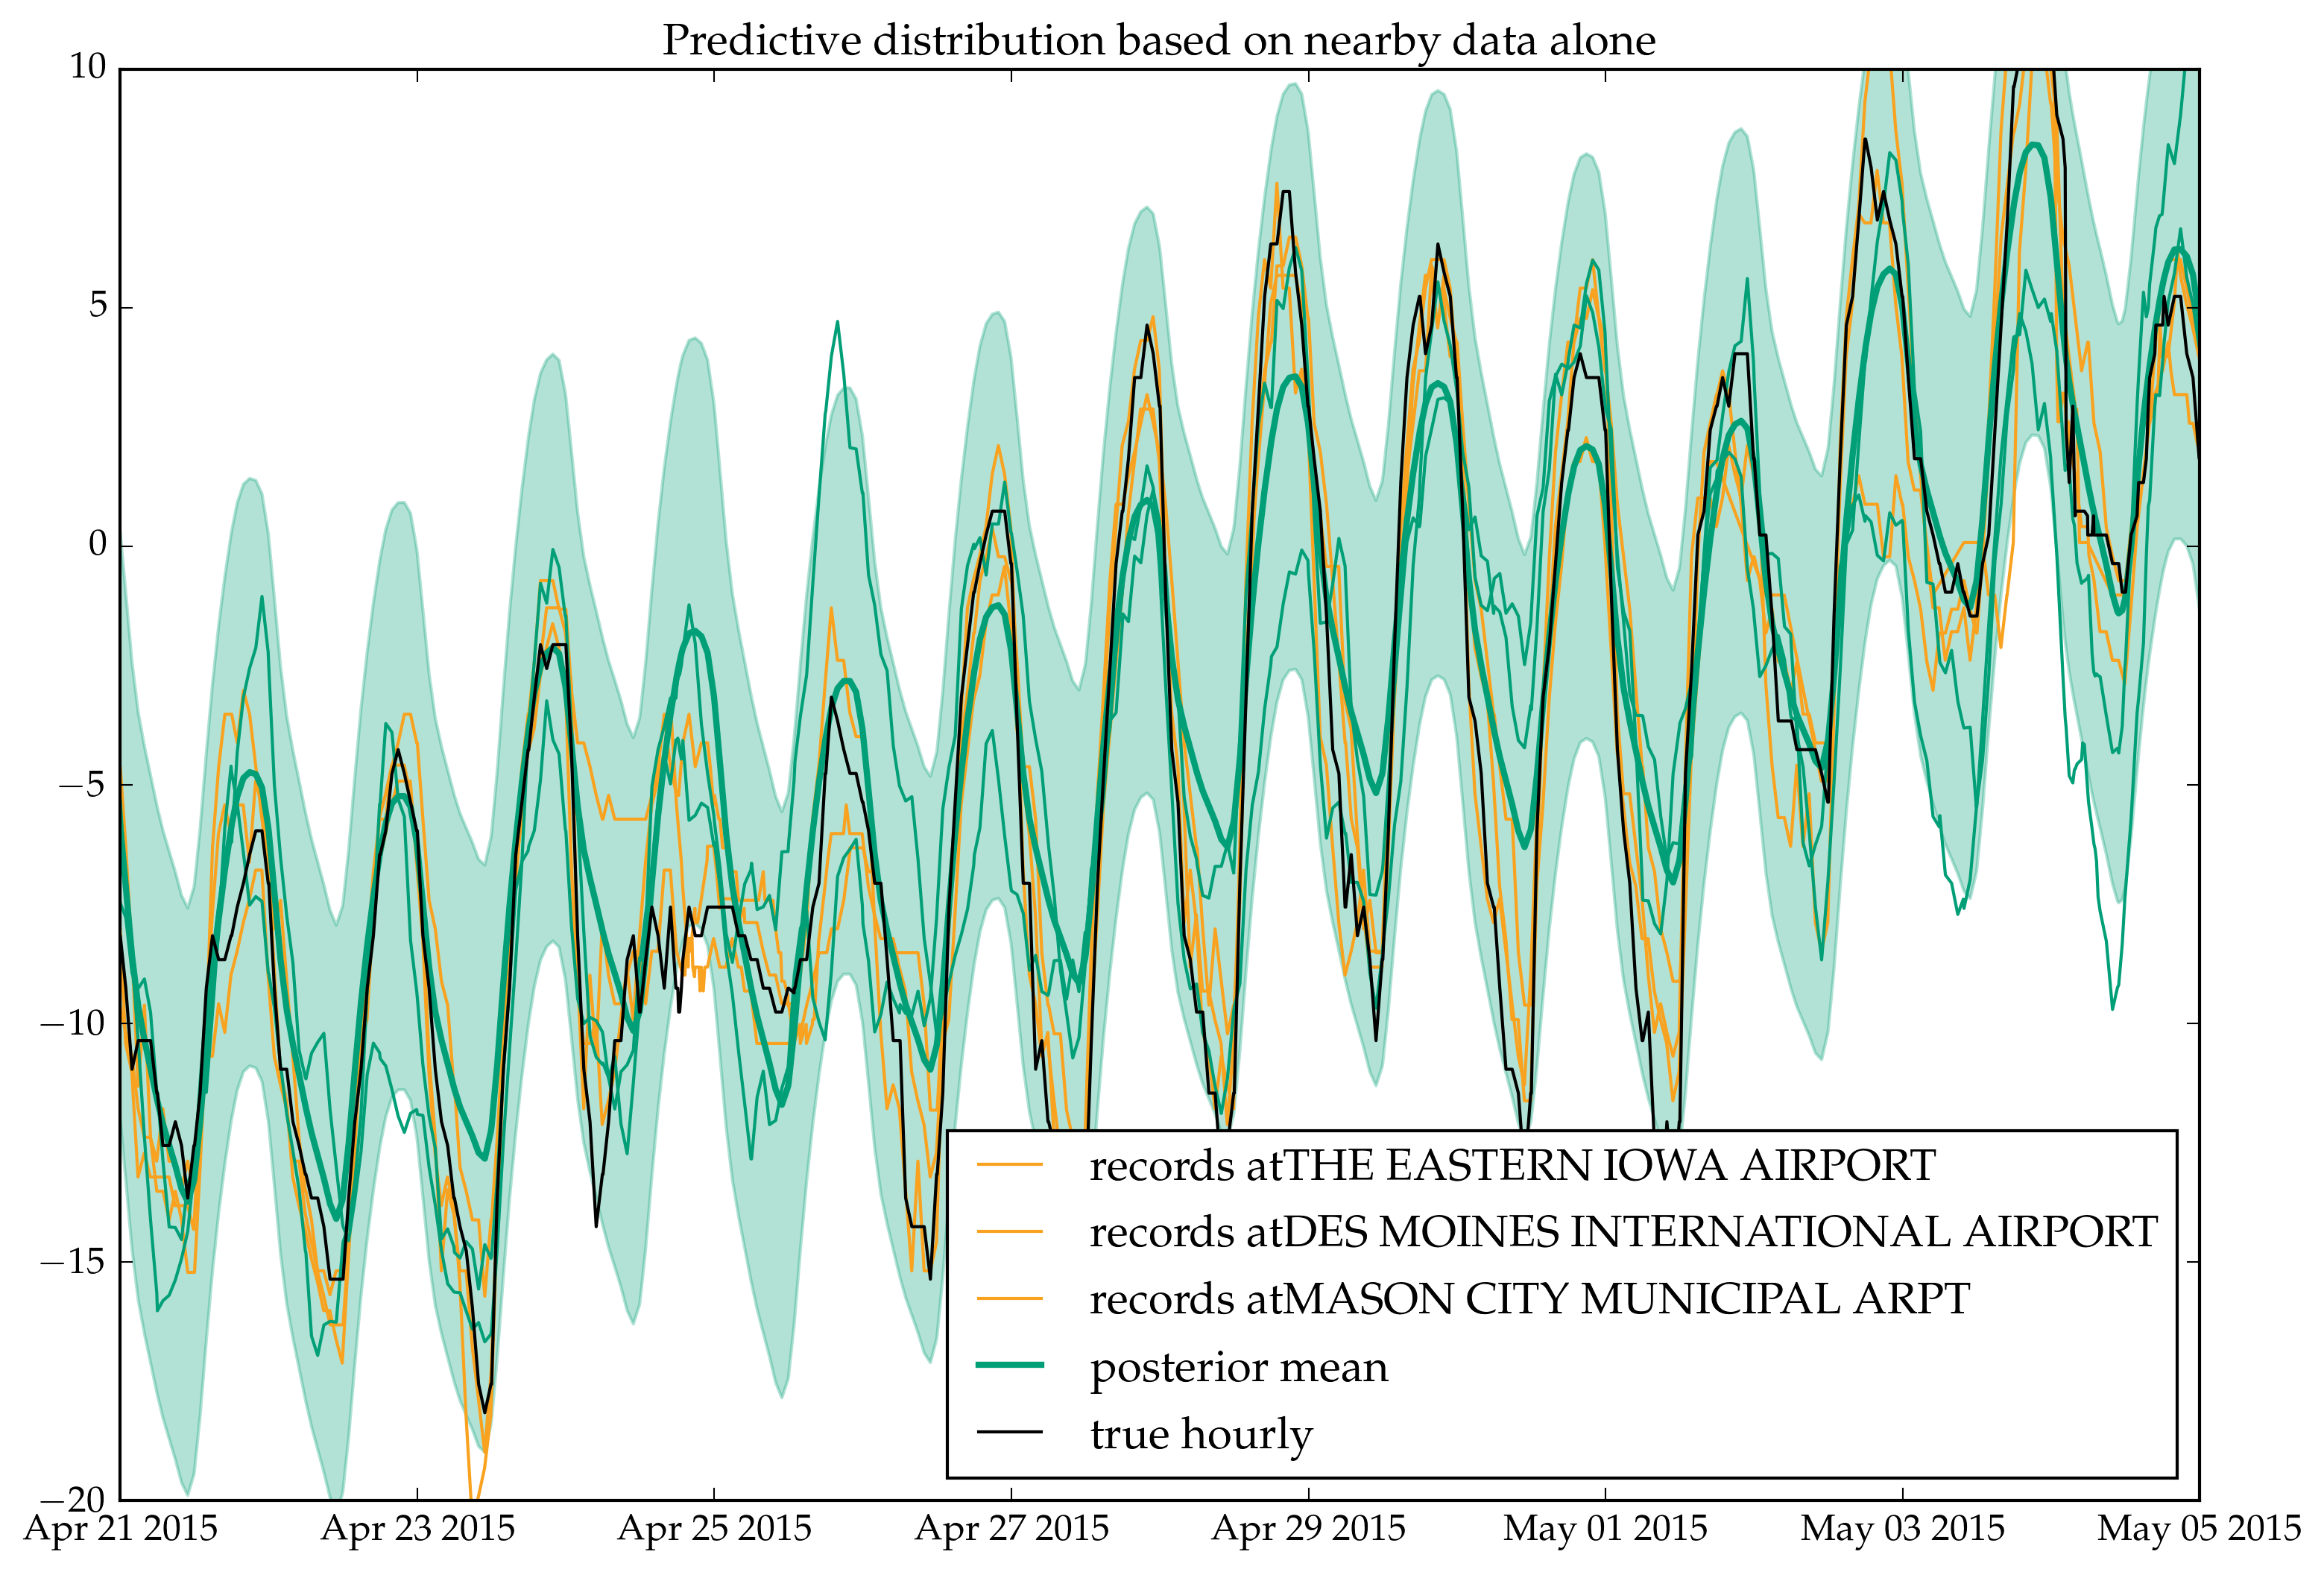

In [48]:
begin
    μ = nearby_pred.μ
    Σ = nearby_pred.Σ
    nobsv = length(μ)
    
    centering = eye(nobsv) .- (1.0/nobsv) .* ones(nobsv, nobsv)
    Σ_centered = centering * Σ.mat * centering
    distr = MultivariateNormal(μ, Σ)
    for station in unique(train_subset[:station].values)
        sdata = train_subset[train_subset[:station].values.==station,:]
        ts=sdata[:ts].values
        plt.plot(ts, sdata[:temp].values.-mean(sdata[:temp].values), color="#F8A21F", 
            label="records at"get(isdSubset[station,:NAME]))
    end
    ts=test_subset[:ts].values
    plt.plot(ts, μ, color="#009F77", linewidth=2, label="posterior mean")
    for _ in 1:2
        temp_sim = rand(distr)
        plt.plot(ts, temp_sim.-mean(temp_sim), color="#009F77", linewidth=1)
    end
    plt.fill_between(ts, μ-2*√diag(Σ_centered),μ+2*√diag(Σ_centered), color="#009F77", alpha=0.3)
    ts = test_subset[:ts].values
    temp_true = test_subset[:temp].values
    plt.plot(ts, temp_true.-mean(temp_true), 
        color="black", "-", label="true hourly")
    plt.legend(loc="best")
    plt.title("Predictive distribution based on nearby data alone")
    plt.xlim(DateTime(2015,4,21),DateTime(2015,5,5))
    plt.ylim(-20,10)
end
;

# Sum of products, all parameters free

In [54]:
GPmodel = "sumprod"

"sumprod"

In [55]:
saved_dir = joinpath(pwd(), "saved/predictions_from_nearby", GPmodel)

jldfiles = readdir(saved_dir)
filepath = jldfiles[5]
nearby_pred=load(joinpath(saved_dir, filepath))["nearby_pred"]

TempModel.NearbyPrediction(DateTime[2015-03-15T00:00:00,2015-03-15T00:54:00,2015-03-15T01:54:00,2015-03-15T02:54:00,2015-03-15T03:54:00,2015-03-15T04:54:00,2015-03-15T05:54:00,2015-03-15T06:00:00,2015-03-15T06:54:00,2015-03-15T07:54:00  …  2015-05-26T19:54:00,2015-05-26T20:04:00,2015-05-26T20:45:00,2015-05-26T20:52:00,2015-05-26T20:54:00,2015-05-26T21:54:00,2015-05-26T22:07:00,2015-05-26T22:34:00,2015-05-26T22:54:00,2015-05-26T23:54:00],[-0.306065,-2.64789,-4.78246,-6.14634,-7.37045,-8.43954,-9.10173,-9.1308,-9.19968,-9.31529  …  8.45069,8.5445,8.82846,8.85483,8.86117,8.88852,8.86866,8.7729,8.61676,7.53763],PDMats.PDMat{Float64,Array{Float64,2}}(2525,[104.896 104.559 … 102.897 102.895; 104.559 104.749 … 102.901 102.899; … ; 102.897 102.901 … 104.728 104.482; 102.895 102.899 … 104.482 104.756],Base.LinAlg.Cholesky{Float64,Array{Float64,2}} with factor:
[10.2419 10.209 … 10.0467 10.0465; 0.0 0.725116 … 0.460482 0.461678; … ; 0.0 0.0 … 0.413324 0.374008; 0.0 0.0 … 0.0 0.693768]))

In [56]:
test_subset = subset(test_trimmed, minimum(nearby_pred.ts), maximum(nearby_pred.ts))
train_subset = subset(hourly_train, minimum(nearby_pred.ts), maximum(nearby_pred.ts))
;

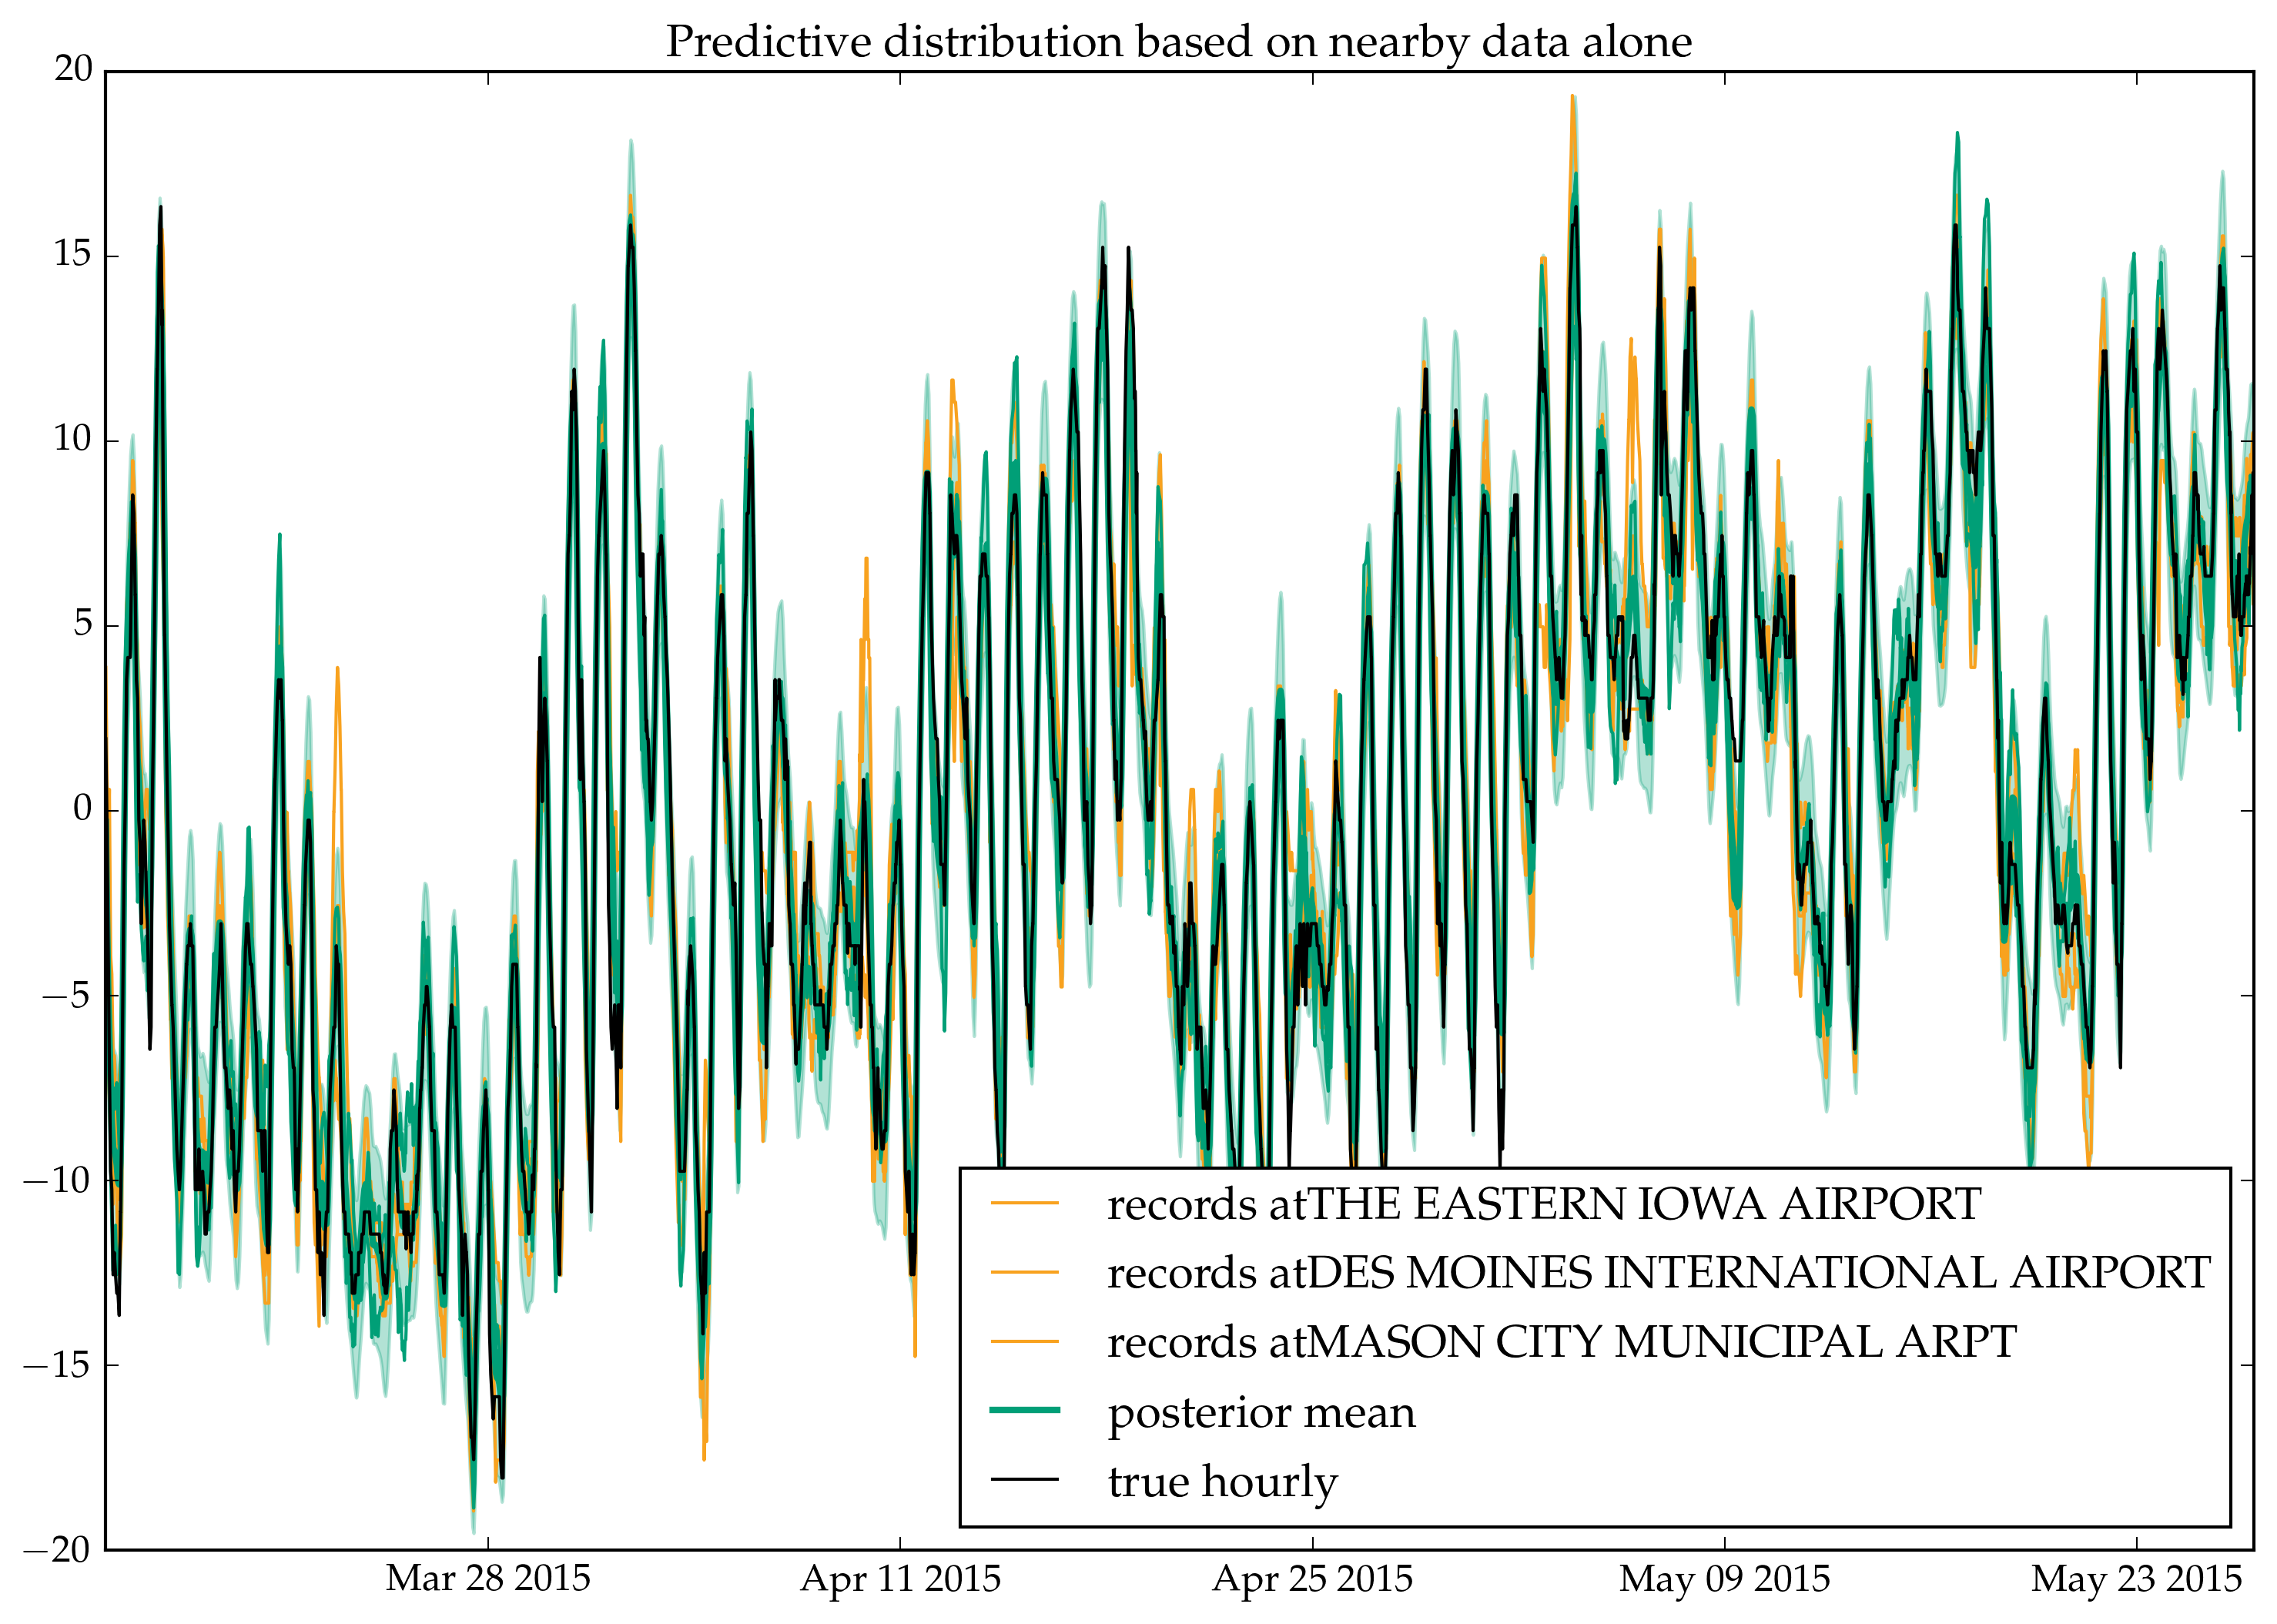

In [58]:
begin
    μ = nearby_pred.μ
    Σ = nearby_pred.Σ
    nobsv = length(μ)
    
    centering = eye(nobsv) .- (1.0/nobsv) .* ones(nobsv, nobsv)
    Σ_centered = centering * Σ.mat * centering
    distr = MultivariateNormal(μ, Σ)
    for station in unique(train_subset[:station].values)
        sdata = train_subset[train_subset[:station].values.==station,:]
        ts=sdata[:ts].values
        plt.plot(ts, sdata[:temp].values.-mean(sdata[:temp].values), color="#F8A21F", 
            label="records at"get(isdSubset[station,:NAME]))
    end
    ts=test_subset[:ts].values
    plt.plot(ts, μ, color="#009F77", linewidth=2, label="posterior mean")
    for _ in 1:2
        temp_sim = rand(distr)
        plt.plot(ts, temp_sim.-mean(temp_sim), color="#009F77", linewidth=1)
    end
    plt.fill_between(ts, μ-2*√diag(Σ_centered),μ+2*√diag(Σ_centered), color="#009F77", alpha=0.3)
    ts = test_subset[:ts].values
    temp_true = test_subset[:temp].values
    plt.plot(ts, temp_true.-mean(temp_true), 
        color="black", "-", label="true hourly")
    plt.legend(loc="best")
    plt.title("Predictive distribution based on nearby data alone")
end
;

In [59]:
begin
    ts=test_subset[:ts].values
    μ = nearby_pred.μ
    Σ = nearby_pred.Σ
    nobsv = length(μ)
    
    centering = eye(nobsv) .- (1.0/nobsv) .* ones(nobsv, nobsv)
    Σ_centered = centering * Σ.mat * centering
    distr = MultivariateNormal(μ, Σ)
#     println("sum(Σ_centered)=", sum(Σ_centered*Σ_centered))
    for _ in 1:5
        temp_sim = rand(distr)
        println("var(predicted mean - simulated prediction)=", var(μ .- temp_sim))
    end
    temp_true = test_subset[:temp].values
    println("E(var(predicted mean - predictive draw))=", mean(var(μ .- rand(distr)) for _ in 1:10000))
    println("var(truth - predicted mean)=", var(μ .- temp_true))
end
;

var(predicted mean - simulated prediction)=1.478819785870583
var(predicted mean - simulated prediction)=1.7986915848920808
var(predicted mean - simulated prediction)=2.0981877784870853
var(predicted mean - simulated prediction)=1.7498186032658833
var(predicted mean - simulated prediction)=1.722181724142037
E(var(predicted mean - predictive draw))=1.7825340544987303
var(truth - predicted mean)=1.4906425206370295


var(truth - predicted mean)=1

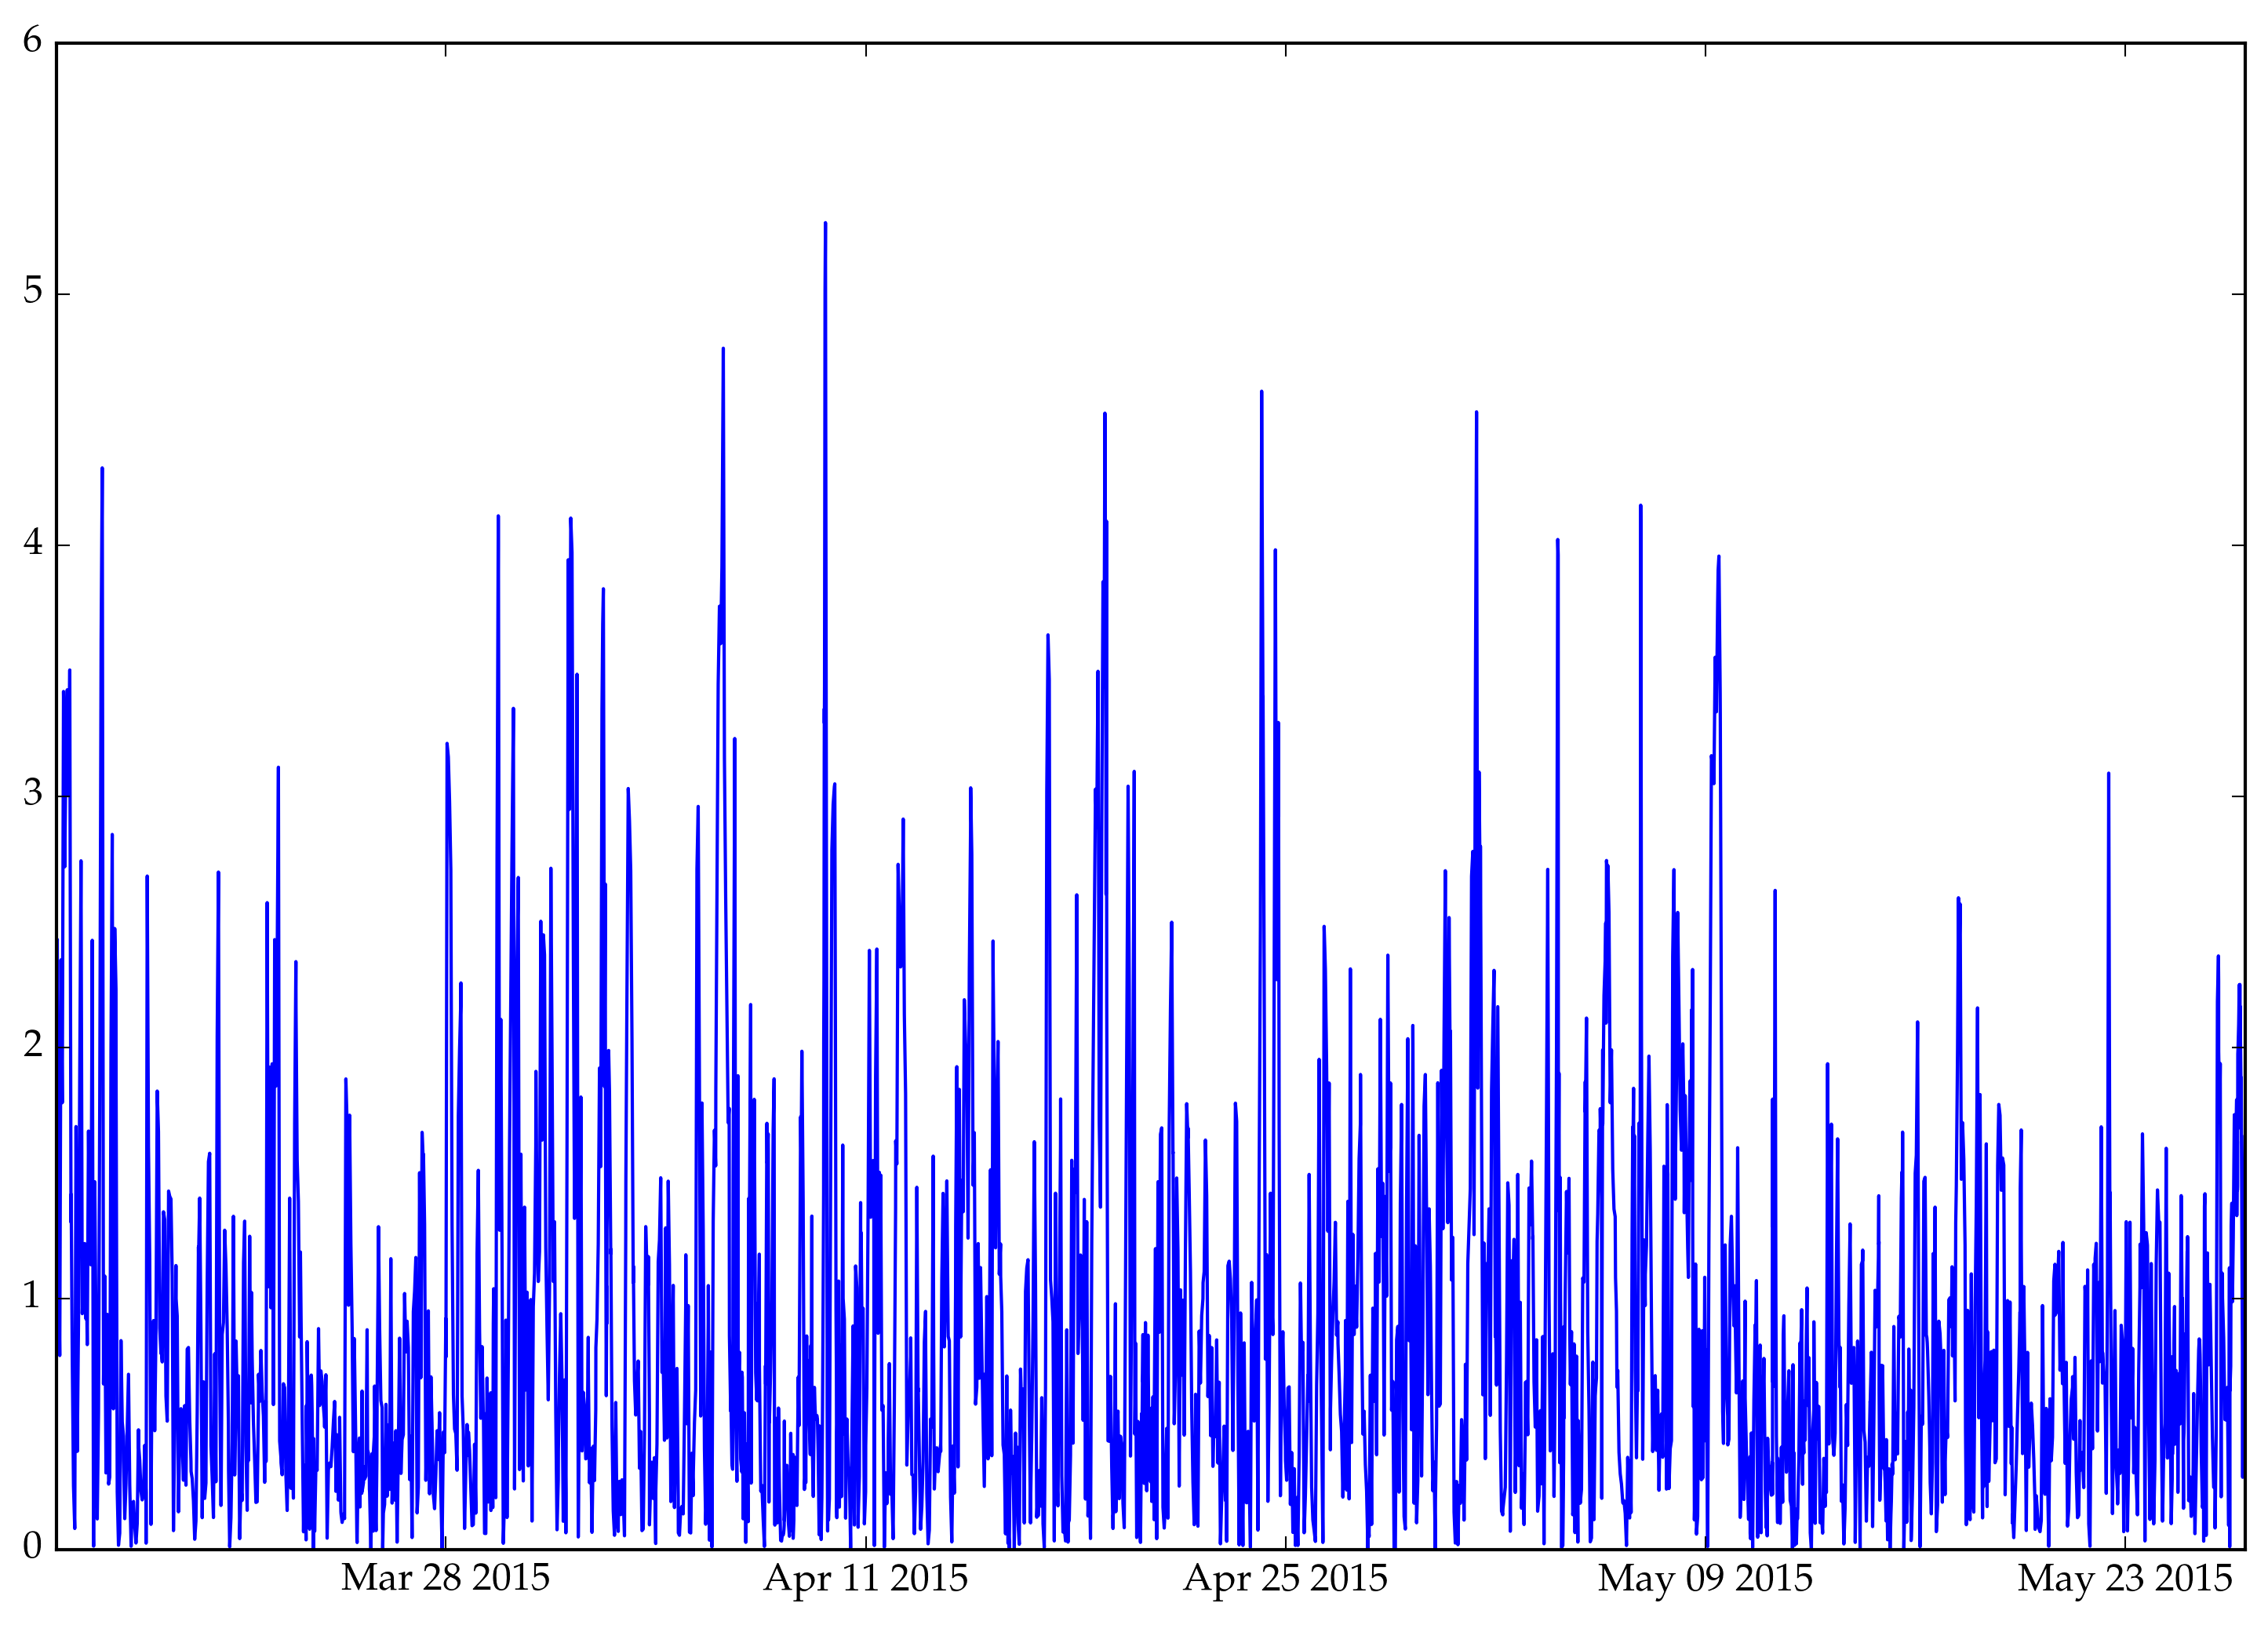

In [60]:
begin
    ts=test_subset[:ts].values
    μ = nearby_pred.μ
    Σ = nearby_pred.Σ
    nobsv = length(μ)
    
    centering = eye(nobsv) .- (1.0/nobsv) .* ones(nobsv, nobsv)
    Σ_centered = centering * Σ.mat * centering
    distr = MultivariateNormal(μ, Σ)
    temp_true = test_subset[:temp].values
    println("var(truth - predicted mean)=", var(μ .- temp_true))
    residuals = μ .- temp_true
    plt.plot(ts, abs(residuals .- mean(residuals)))
end
;

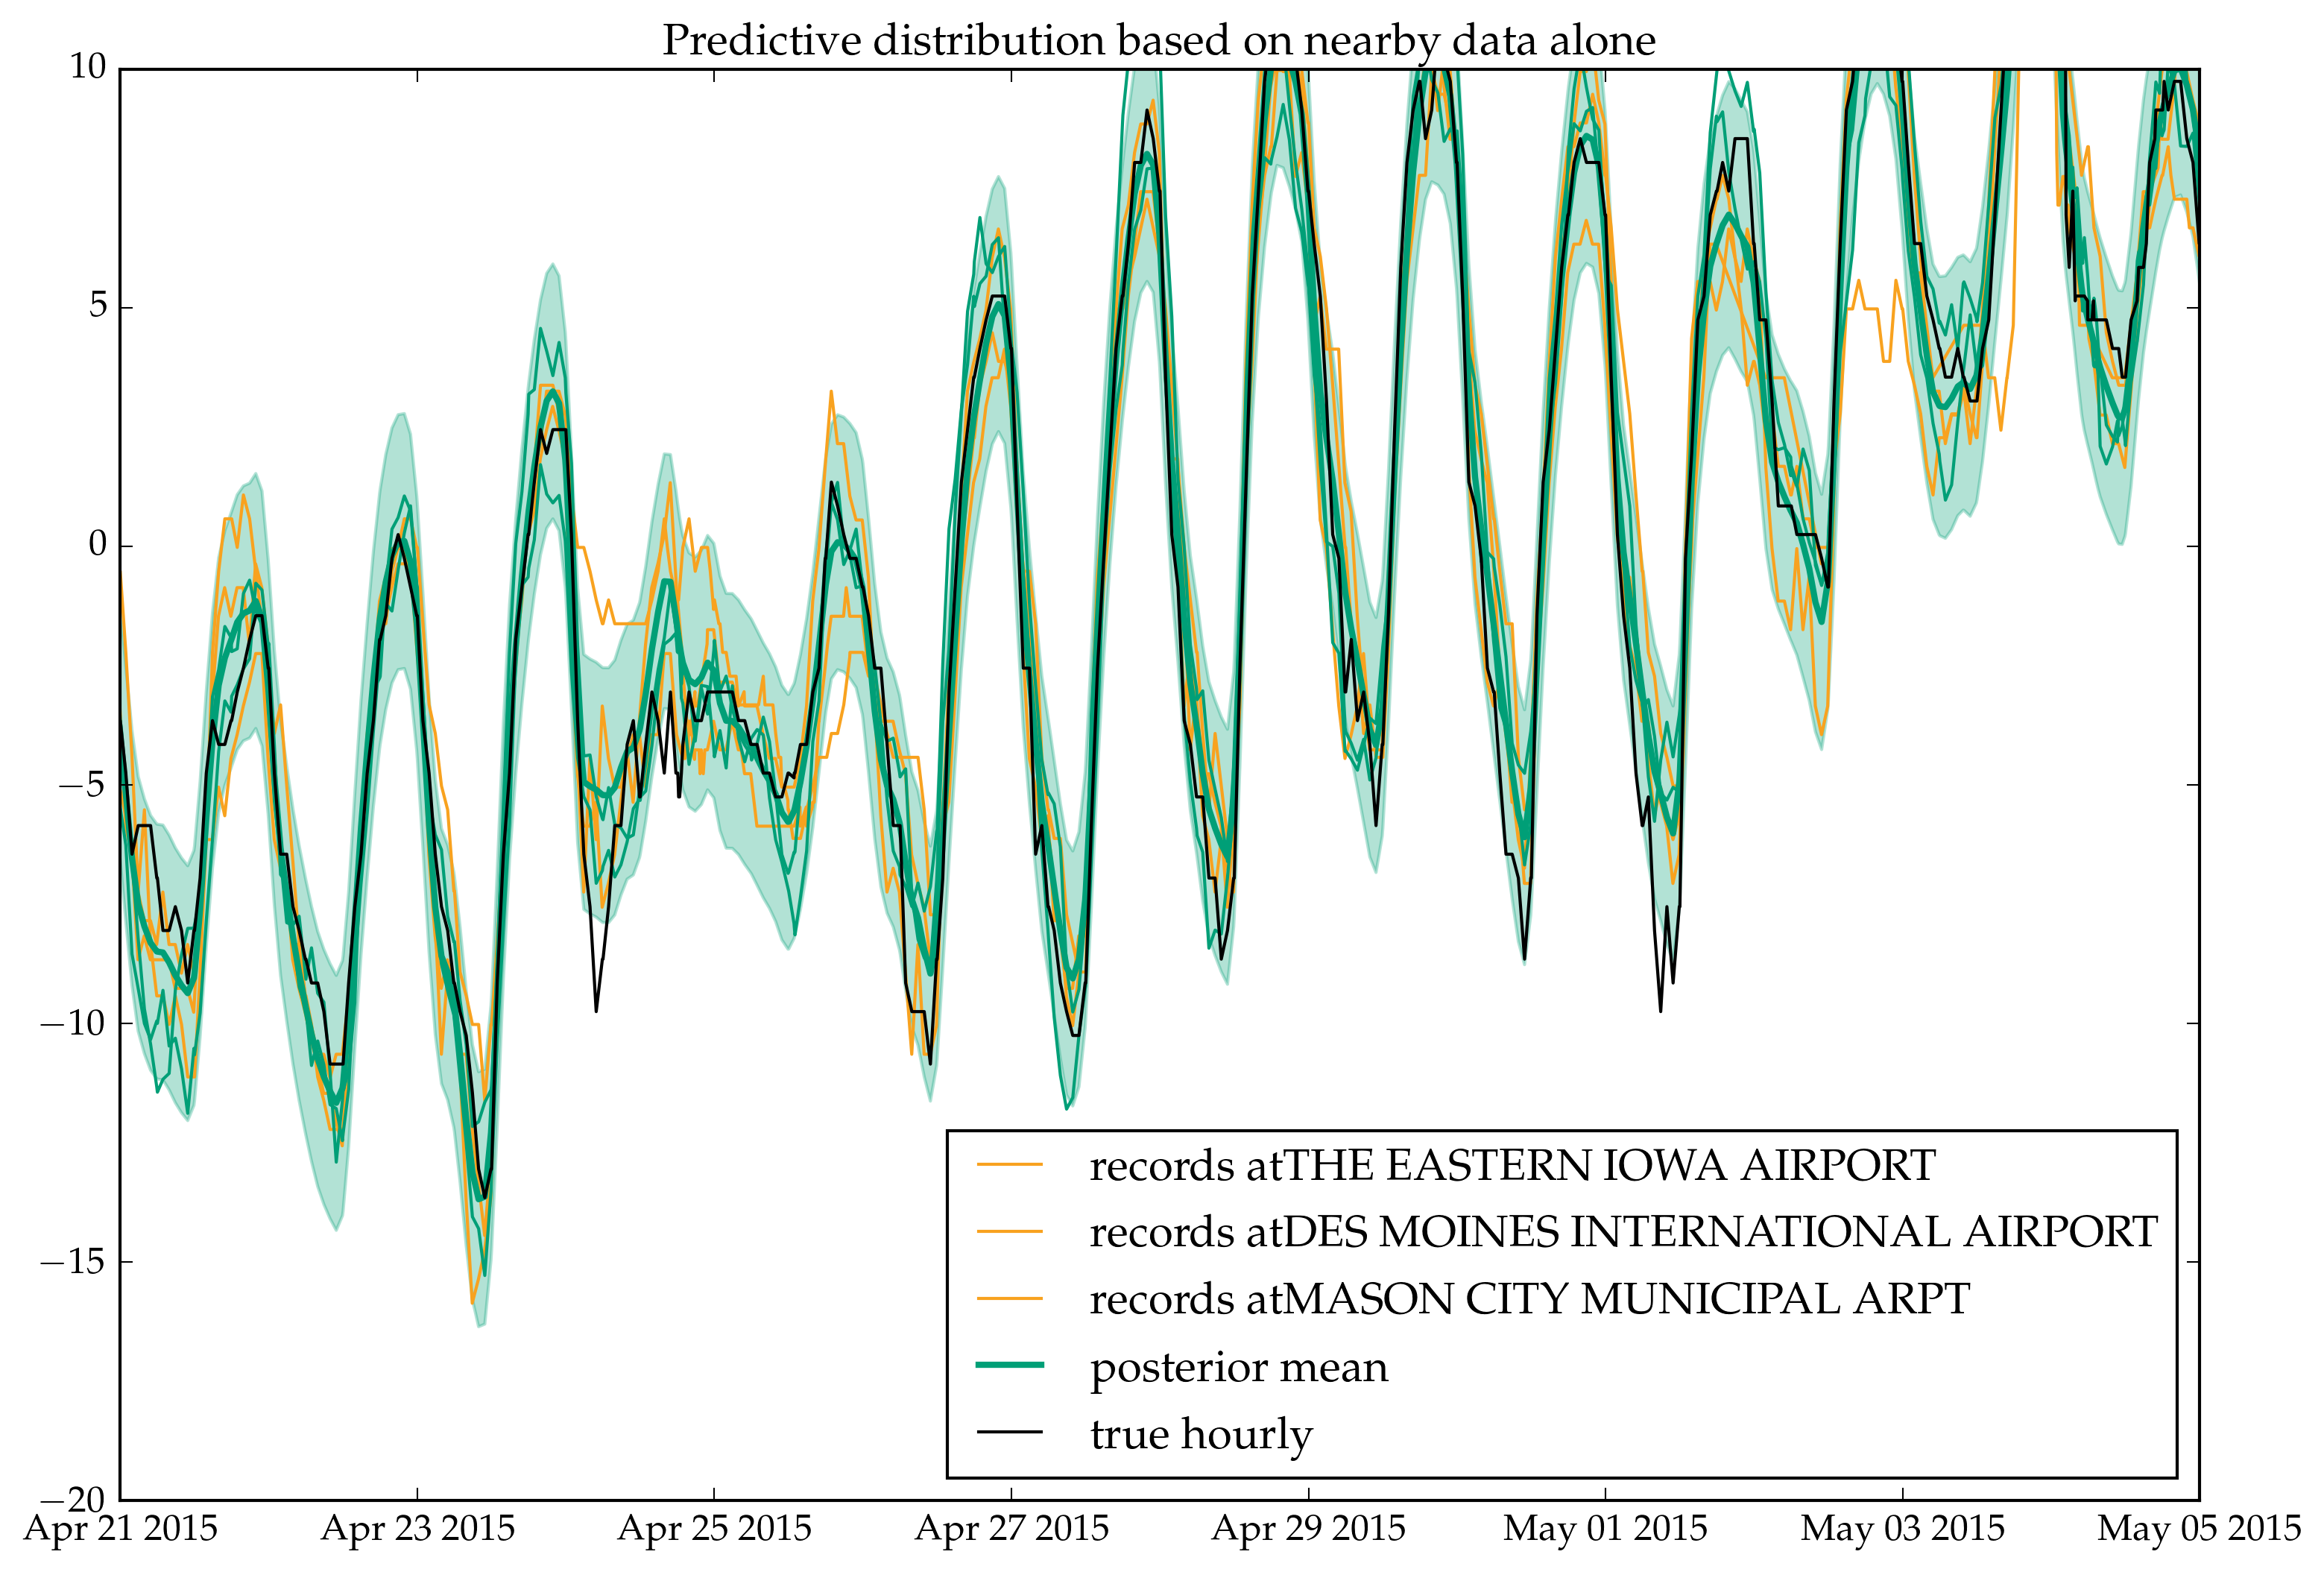

In [61]:
begin
    μ = nearby_pred.μ
    Σ = nearby_pred.Σ
    nobsv = length(μ)
    
    centering = eye(nobsv) .- (1.0/nobsv) .* ones(nobsv, nobsv)
    Σ_centered = centering * Σ.mat * centering
    distr = MultivariateNormal(μ, Σ)
    for station in unique(train_subset[:station].values)
        sdata = train_subset[train_subset[:station].values.==station,:]
        ts=sdata[:ts].values
        plt.plot(ts, sdata[:temp].values.-mean(sdata[:temp].values), color="#F8A21F", 
            label="records at"get(isdSubset[station,:NAME]))
    end
    ts=test_subset[:ts].values
    plt.plot(ts, μ, color="#009F77", linewidth=2, label="posterior mean")
    for _ in 1:2
        temp_sim = rand(distr)
        plt.plot(ts, temp_sim.-mean(temp_sim), color="#009F77", linewidth=1)
    end
    plt.fill_between(ts, μ-2*√diag(Σ_centered),μ+2*√diag(Σ_centered), color="#009F77", alpha=0.3)
    ts = test_subset[:ts].values
    temp_true = test_subset[:temp].values
    plt.plot(ts, temp_true.-mean(temp_true), 
        color="black", "-", label="true hourly")
    plt.legend(loc="best")
    plt.title("Predictive distribution based on nearby data alone")
    plt.xlim(DateTime(2015,4,21),DateTime(2015,5,5))
    plt.ylim(-20,10)
end
;